In [8]:
# PASO 1 ─── instalar SOLO lo que falta y en versiones compatibles con NumPy 2.0
!pip install --upgrade -q \
    scikit-learn==1.4.2 \
    opencv-python-headless \
    matplotlib seaborn

In [9]:
import os, cv2, random, numpy as np
from collections import Counter

# Ajusta estas dos variables:
RUTA_DATASET  = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_2_Extraer_caracteristicas_usando_modelo_preentrenado/LabelMe-12-50k/train"
PORC_MUESTRA  = 0.50      # 10 % de cada clase
# MAX_POR_CLASE = 300     # (opcional) usa esta línea en vez de PORC_MUESTRA

IMG_SIZE = (224, 224)
SEED     = 42


In [10]:
def cargar_imagenes_sampleadas(directorio, size=(224,224),
                               porc_clase=None, max_clase=None, seed=42):
    assert (porc_clase is None) ^ (max_clase is None), "elige porc_clase o max_clase, no ambos"
    rng = random.Random(seed)
    X, y, dims, corrupt = [], [], [], 0

    for clase in sorted(os.listdir(directorio)):
        carpeta = os.path.join(directorio, clase)
        if not os.path.isdir(carpeta): continue
        archivos = [os.path.join(carpeta, f) for f in os.listdir(carpeta)]
        rng.shuffle(archivos)

        n = (max_clase if max_clase is not None
             else max(1, int(len(archivos)*porc_clase)))
        for path in archivos[:n]:
            img = cv2.imread(path)
            if img is None:
                corrupt += 1
                continue
            dims.append(img.shape[:2])
            img = cv2.resize(img, size)
            X.append(img); y.append(clase)

    print(f"Imágenes cargadas: {len(X)}  |  Corruptas omitidas: {corrupt}")
    print("Distribución de clases:", Counter(y))
    print("Dimensiones originales más comunes:", Counter(dims).most_common(3))
    return np.array(X), np.array(y)

# === Carga la muestra ===
X_img, y = cargar_imagenes_sampleadas(RUTA_DATASET,
                                      porc_clase=PORC_MUESTRA,
                                      # max_clase=MAX_POR_CLASE,
                                      size=IMG_SIZE, seed=SEED)



Imágenes cargadas: 20000  |  Corruptas omitidas: 0
Distribución de clases: Counter({'0000': 500, '0001': 500, '0002': 500, '0003': 500, '0004': 500, '0005': 500, '0006': 500, '0007': 500, '0008': 500, '0009': 500, '0010': 500, '0011': 500, '0012': 500, '0013': 500, '0014': 500, '0015': 500, '0016': 500, '0017': 500, '0018': 500, '0019': 500, '0020': 500, '0021': 500, '0022': 500, '0023': 500, '0024': 500, '0025': 500, '0026': 500, '0027': 500, '0028': 500, '0029': 500, '0030': 500, '0031': 500, '0032': 500, '0033': 500, '0034': 500, '0035': 500, '0036': 500, '0037': 500, '0038': 500, '0039': 500})
Dimensiones originales más comunes: [((256, 256), 20000)]


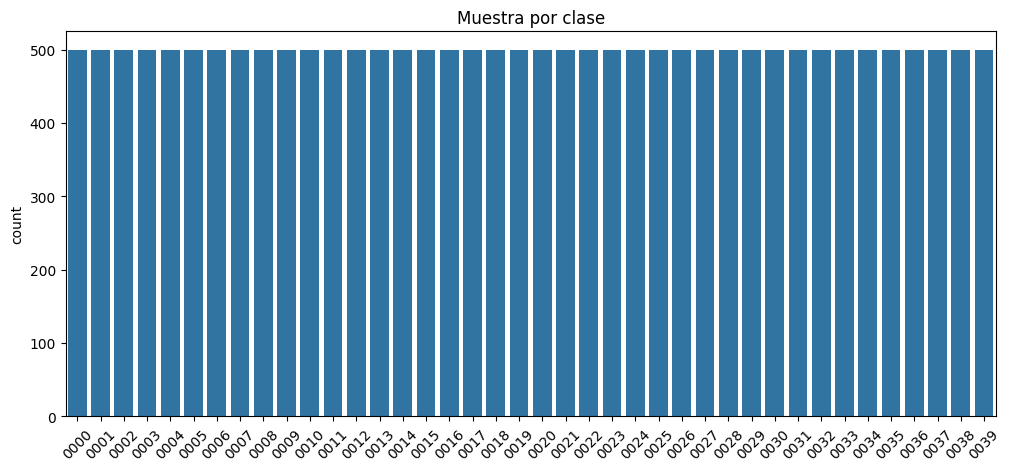

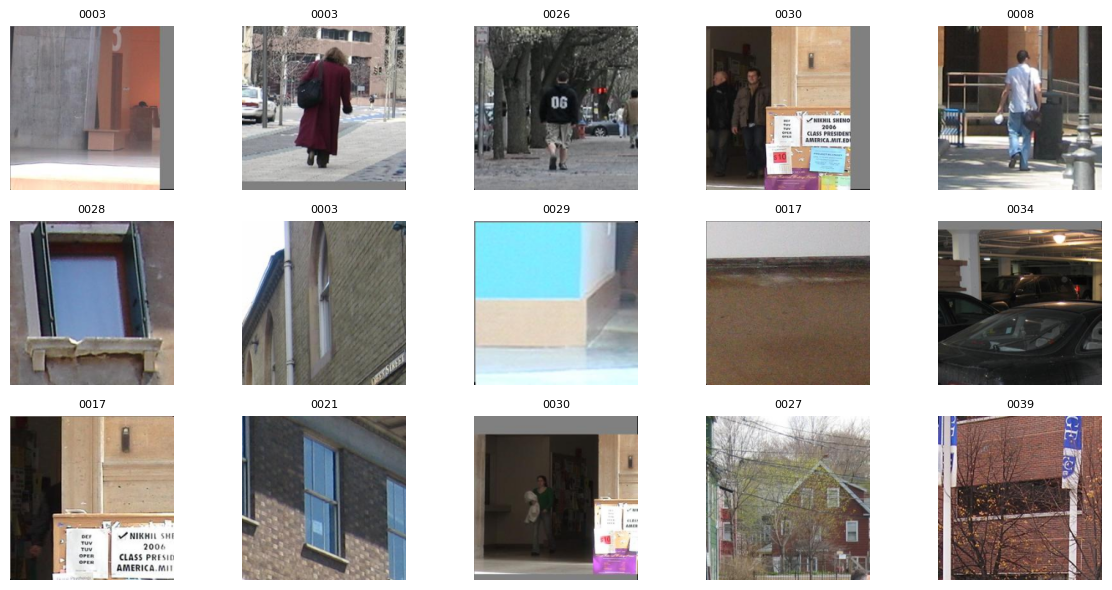

In [11]:
import matplotlib.pyplot as plt, seaborn as sns
# Conteo por clase
plt.figure(figsize=(12,5))
sns.countplot(x=y, order=sorted(set(y))); plt.xticks(rotation=45); plt.title("Muestra por clase")
plt.show()

# Muestras aleatorias
rng = np.random.default_rng(SEED)
muestra = rng.choice(len(X_img), 15, replace=False)
plt.figure(figsize=(12,6))
for i, idx in enumerate(muestra, 1):
    plt.subplot(3,5,i); plt.imshow(cv2.cvtColor(X_img[idx], cv2.COLOR_BGR2RGB))
    plt.axis('off'); plt.title(y[idx], fontsize=8)
plt.tight_layout(); plt.show()


In [12]:
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input

resnet = ResNet50(weights='imagenet', include_top=False, pooling='avg')

def extraer_features(modelo, imgs, batch=32):
    imgs_rgb = np.stack([cv2.cvtColor(i, cv2.COLOR_BGR2RGB) for i in imgs])
    imgs_pp  = preprocess_input(imgs_rgb)
    return modelo.predict(imgs_pp, batch_size=batch, verbose=1)

X_feat = extraer_features(resnet, X_img)
print("Shape features:", X_feat.shape)


94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
625/625 ━━━━━━━━━━━━━━━━━━━━ 703s 1s/step
Shape features: (20000, 2048)


In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.svm import SVC

le        = LabelEncoder()
y_encoded = le.fit_transform(y)

X_tr, X_te, y_tr, y_te = train_test_split(
    X_feat, y_encoded, test_size=0.2, stratify=y_encoded, random_state=SEED)

clf = SVC(kernel='linear', probability=True)
clf.fit(X_tr, y_tr)


SVC(kernel='linear', probability=True)

Accuracy: 0.0285
              precision    recall  f1-score   support

        0000       0.01      0.02      0.02       100
        0001       0.01      0.01      0.01       100
        0002       0.04      0.05      0.04       100
        0003       0.02      0.03      0.03       100
        0004       0.04      0.03      0.03       100
        0005       0.02      0.02      0.02       100
        0006       0.02      0.03      0.03       100
        0007       0.05      0.07      0.06       100
        0008       0.02      0.02      0.02       100
        0009       0.03      0.03      0.03       100
        0010       0.03      0.03      0.03       100
        0011       0.04      0.04      0.04       100
        0012       0.03      0.03      0.03       100
        0013       0.00      0.00      0.00       100
        0014       0.02      0.02      0.02       100
        0015       0.02      0.02      0.02       100
        0016       0.02      0.02      0.02       100
        00

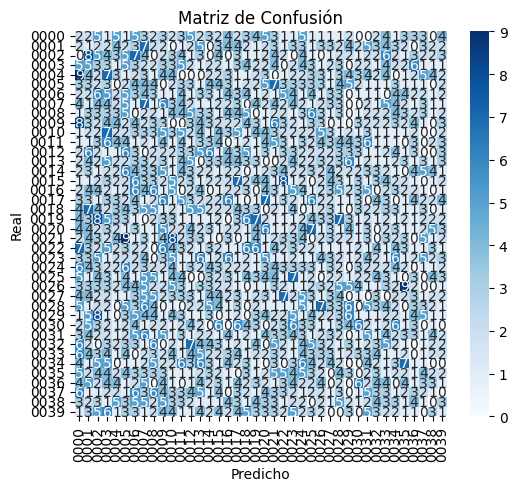

In [14]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns, matplotlib.pyplot as plt

y_pred = clf.predict(X_te)
print("Accuracy:", accuracy_score(y_te, y_pred))
print(classification_report(y_te, y_pred, target_names=le.classes_))

cm = confusion_matrix(y_te, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Matriz de Confusión"); plt.ylabel("Real"); plt.xlabel("Predicho")
plt.show()


In [15]:
import joblib, numpy as np
joblib.dump(clf, "svm_resnet50.pkl")
np.save("features.npy", X_feat); np.save("labels.npy", y_encoded)


# Prueba 2 luego de experimento inical

In [16]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    brightness_range=[0.8, 1.2],
    preprocessing_function=preprocess_input)

# Construir batches aumentados a partir de la muestra cargada
BATCH  = 32
EPOCHS = 5


In [17]:
train_gen = datagen.flow(
    X_img,                       # imágenes RGB originales
    le.transform(y),             # etiquetas codificadas
    batch_size=BATCH,
    shuffle=True)

In [18]:
# Modelo compacto: ResNet50 congelada + capa densa
base = ResNet50(weights='imagenet', include_top=False, pooling='avg')
base.trainable = False          # congelamos todos los pesos

In [19]:
import tensorflow as tf
inputs  = tf.keras.Input(shape=(224,224,3))
x = base(inputs, training=False)
outputs = tf.keras.layers.Dense(len(le.classes_), activation='softmax')(x)
model   = tf.keras.Model(inputs, outputs)

In [20]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
model.fit(train_gen, epochs=EPOCHS, steps_per_epoch=len(X_img)//BATCH)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 748s 1s/step - accuracy: 0.0229 - loss: 4.0196
Epoch 2/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 740s 1s/step - accuracy: 0.0288 - loss: 3.8445
Epoch 3/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 741s 1s/step - accuracy: 0.0317 - loss: 3.7759
Epoch 4/5
625/625 ━━━━━━━━━━━━━━━━━━━━ 741s 1s/step - accuracy: 0.0367 - loss: 3.7256
Epoch 5/5
483/625 ━━━━━━━━━━━━━━━━━━━━ 2:54 1s/step - accuracy: 0.0432 - loss: 3.6913

In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau

# Descongela las últimas ~23 capas (conv5_block)
for layer in base.layers[-23:]:
    layer.trainable = True

opt = tf.keras.optimizers.Adam(1e-5)
model.compile(opt, 'sparse_categorical_crossentropy', metrics=['accuracy'])

# Pesos inversamente proporcionales a frecuencia
from sklearn.utils.class_weight import compute_class_weight
cw = compute_class_weight('balanced', classes=np.unique(y_encoded), y=y_encoded)
class_w = {i:w for i,w in enumerate(cw)}

rlr = ReduceLROnPlateau(monitor='accuracy', factor=0.3, patience=3, min_lr=3e-6)

history = model.fit(train_gen,
                    epochs=15,
                    steps_per_epoch=len(X_img)//BATCH,
                    class_weight=class_w,
                    callbacks=[rlr])


Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1034s 2s/step - accuracy: 0.0509 - loss: 3.6617 - learning_rate: 1.0000e-05
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 1015s 2s/step - accuracy: 0.0600 - loss: 3.6064 - learning_rate: 1.0000e-05
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 997s 2s/step - accuracy: 0.0644 - loss: 3.5619 - learning_rate: 1.0000e-05
Epoch 4/15
145/625 ━━━━━━━━━━━━━━━━━━━━ 12:47 2s/step - accuracy: 0.0731 - loss: 3.5405

In [ ]:
import os
import glob
import random
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report
import joblib

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

# ── 0) Configuración general ────────────────────────────────────────────────────
SEED        = 42
random.seed(SEED)
np.random.seed(SEED)
tf.random.set_seed(SEED)

DATA_DIR    = "/content/drive/MyDrive/Procesamiento Imagenes/Taller_2_Extraer_caracteristicas_usando_modelo_preentrenado/LabelMe-12-50k/train"
IMG_SIZE    = (224, 224)
BATCH_SIZE  = 32
FRAC        = 0.05      # 5% de cada clase
VAL_SPLIT   = 0.20      # 20% validación sobre el 5%
N_CLASSES   = 40
FEATURE_DIR = "/tmp/features"  # (opcional) para guardar en disco

# ── 1) Muestreo del 5% por clase y construcción de DataFrame ────────────────────
filepaths = []
labels    = []

for class_name in os.listdir(DATA_DIR):
    class_dir = os.path.join(DATA_DIR, class_name)
    if not os.path.isdir(class_dir):
        continue

    imgs = glob.glob(os.path.join(class_dir, "*.jpg"))  # o *.png según tus archivos
    n_sample = max(1, int(len(imgs) * FRAC))
    sampled = random.sample(imgs, n_sample)

    filepaths += sampled
    labels    += [class_name] * len(sampled)

df = pd.DataFrame({
    "filepath": filepaths,
    "label":    labels
})

# ── 2) División estratificada en train / val ────────────────────────────────────
train_df, val_df = train_test_split(
    df,
    test_size=VAL_SPLIT,
    stratify=df["label"],
    random_state=SEED
)

# ── 3) Generadores de datos con augmentación ───────────────────────────────────
train_datagen = ImageDataGenerator(
    rescale=1.0/255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True
)
val_datagen = ImageDataGenerator(rescale=1.0/255)

train_gen = train_datagen.flow_from_dataframe(
    train_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=True,
    seed=SEED
)
val_gen = val_datagen.flow_from_dataframe(
    val_df,
    x_col="filepath",
    y_col="label",
    target_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    class_mode="sparse",
    shuffle=False
)

# ── 4) Transfer Learning: ResNet50 + cabezal personalizado ─────────────────────
base_model = ResNet50(
    weights="imagenet",
    include_top=False,
    input_shape=(*IMG_SIZE, 3)
)
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(256, activation="relu")(x)
x = Dropout(0.3)(x)
outputs = Dense(N_CLASSES, activation="softmax")(x)

tl_model = Model(inputs=base_model.input, outputs=outputs)
tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

callbacks = [
    EarlyStopping(monitor="val_accuracy", patience=5, restore_best_weights=True),
    ReduceLROnPlateau(monitor="val_loss", factor=0.5, patience=3, min_lr=1e-6),
    ModelCheckpoint("best_tl_model.h5", monitor="val_accuracy", save_best_only=True)
]

# Entrenar solo la cabeza
tl_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=20,
    callbacks=callbacks
)

# Opcional: fine-tuning de las últimas 10 capas convolucionales
for layer in base_model.layers[-10:]:
    layer.trainable = True

tl_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)
tl_model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=10,
    callbacks=callbacks
)

# ── 5) Extracción de features con la parte convolucional ──────────────────────
def extract_features(generator, sample_count):
    features = np.zeros((sample_count, 7*7*2048), dtype=np.float32)
    labels   = np.zeros((sample_count,), dtype=np.int32)
    i = 0
    for batch_imgs, batch_labels in generator:
        feats = base_model.predict(batch_imgs, verbose=0)
        feats = feats.reshape(feats.shape[0], -1)
        batch_size = feats.shape[0]
        features[i : i+batch_size] = feats
        labels[i : i+batch_size]   = batch_labels
        i += batch_size
        if i >= sample_count:
            break
    return features, labels

X_train, y_train = extract_features(train_gen, train_gen.samples)
X_val,   y_val   = extract_features(val_gen,   val_gen.samples)

# ── 6) Escalado y entrenamiento de un SVM con búsqueda de hiperparámetros ────
scaler = StandardScaler().fit(X_train)
X_tr_s = scaler.transform(X_train)
X_va_s = scaler.transform(X_val)

svm = SVC(class_weight="balanced", probability=False, random_state=SEED)
param_grid = {
    "C":      [1, 10],
    "kernel": ["rbf", "linear"],
    "gamma":  ["scale", "auto"]
}
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=SEED)

grid = GridSearchCV(
    svm,
    param_grid,
    scoring="f1_macro",
    cv=cv,
    n_jobs=-1,
    verbose=2
)
grid.fit(X_tr_s, y_train)

print("Mejores parámetros SVM:", grid.best_params_)

# ── 7) Evaluación final ────────────────────────────────────────────────────────
y_pred = grid.predict(X_va_s)
print(classification_report(y_val, y_pred, digits=4))

# ── 8) Guardar artefactos para producción ──────────────────────────────────────
joblib.dump(scaler,           "scaler.pkl")
joblib.dump(grid.best_estimator_, "svm_resnet50_best.pkl")
tl_model.save("resnet50_finetuned.h5")
